# Does maximisation of net carbon profit explain vegetation behaviour in savanna sites along a precipitation gradient?

It was shown by Whitley et al. (2016) that six models that expliticly included land surface exchange and vegetation dynamics (i.e. terrestial biosphere models, TBM's) were not able to represent, especially, the wet season dynamics in savanna regions. This reflects generally the simplicity used in the current generation TBM's with regard to modelling vegetation, which becomes especially apparent in the more complex ecosystems of savannas. The understanding of these more complex interactions between vegetation, water and climate in savanna-sites is therefore crucial in order to improve modelling with TBM's. 
Similar to the model inter-comparison presented by Whitley et al. (2016), in this study a coupled water-vegetation model (VOM, Schymanski et al. 2009) is applied in several savanna sites. In this case, vegetation properties are optimized for net carbon profit, instead of prescribing these.

The hypotheses tested are:

- Observed vegetation dynamics in tropical savanna sites can be explained by the maximization of Net Carbon Profit. 

- Optimization of vegetation properties for the Net Carbon Profit leads to reduced data requirements for Land Surface Models

- Carbon cost functions for roots, water transport system and foliage are valid along a precipitation gradient




# Results

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from matplotlib.pyplot import imread
import matplotlib.cbook as cbook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Model comparison

In [2]:
def ensemble_year(vals, time):

    
    
    ens = np.zeros([366])
    ens7d = np.zeros([367])
    
    
    DOY = time.dayofyear[0:len(vals)] 

    for iday in range(0,366):
        ens[iday] = np.mean( vals[DOY == (iday+1)]  ) 
        
    #7-day running mean
    N = 7
    for iday in range(0,367):
        if iday > (366-N):
            ens7d[iday]  = np.mean( np.concatenate( (ens[iday:366], ens[0:(N-(366-iday))] )) )

        else:    
            ens7d[iday] = np.mean(ens[iday:(iday+N)])
            
    return ens7d


### Ensemble years

GPP Litchfield


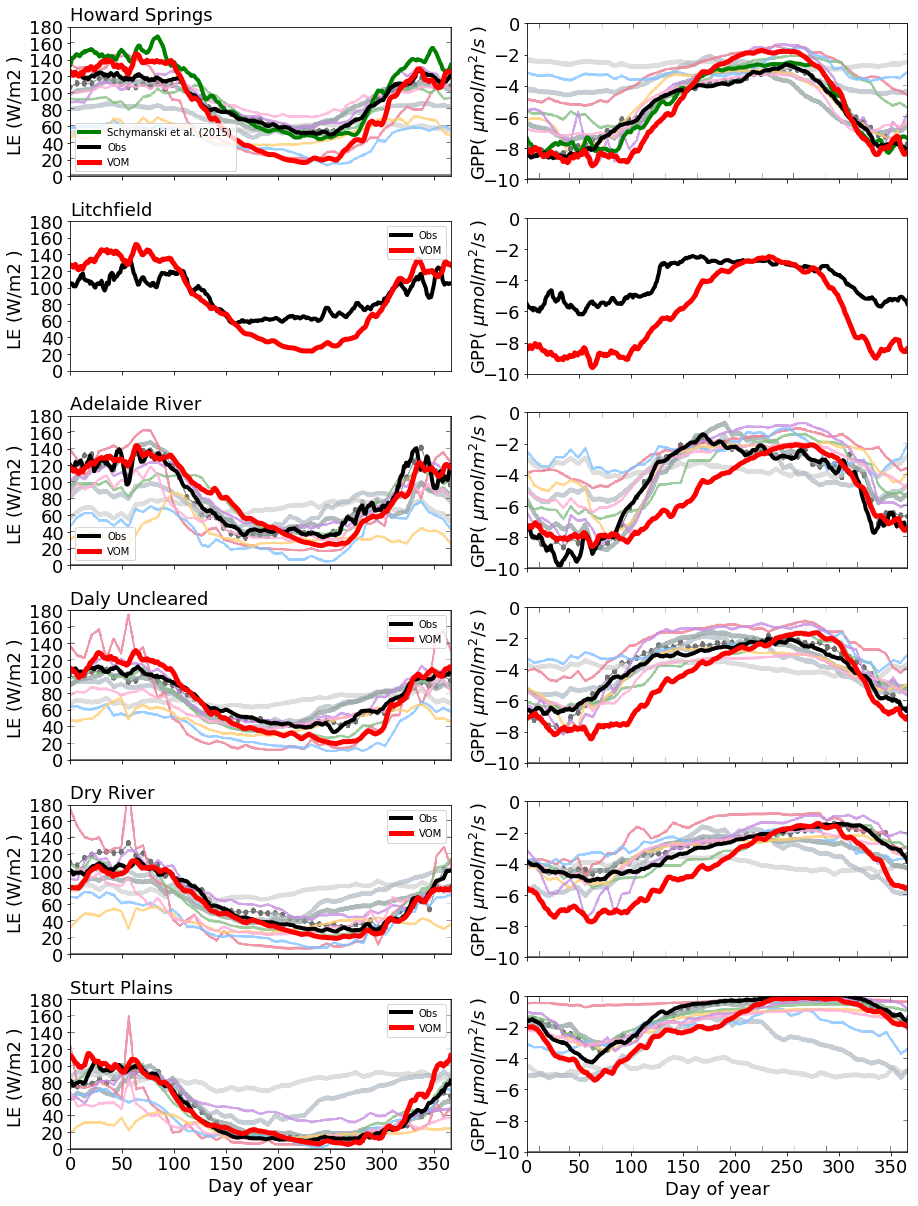

In [3]:
#ensemble year

site = ["HowardSprings","Litchfield", "AdelaideRiver", "DalyUncleared", "DryRiver",  "SturtPlains"]
site_name = ["Howard Springs","Litchfield", "Adelaide River", "Daly Uncleared", "Dry River",  "Sturt Plains"]
site_short = ["howard","litch","adelaide", "daly",  "dry",  "sturt"]

#year to plot per catchment
yearstart = [2006, 2008, 2015, 2004, 2010]
yearend = [2008, 2010, 2017, 2006, 2012] 

const = 2.16679         #[g*K/J]
lat_heat_vapor = 2.45   #[MJ/kg] 
rho_w = 997             #[kg/m3]
CO2MW = 44.01           #[g/mol]
R = 8.314               #[J/mol/K]
atm_press = 1023.25     #[hPa]
std_tmp = 25.0          #[oC]
temp_conv = 273.15      #[K]


colors = ['red','red','red','red','green', 'orange' ]
iplot = 0

fig, axes   = plt.subplots(nrows=6, ncols=2, figsize=(15, 23), sharex=True,gridspec_kw = {'wspace':0.2, 'hspace':-0.3} )
ax = axes.flat


#loop over study sites
for isite in  np.array([0, 1, 2, 3, 4, 5 ]):  

    #load fluxtower observations
    ea_tmp = np.loadtxt("../data/DINGO/Ea_"+ site_short[isite] +".txt", usecols=2) #mm/d
    tobs =  np.genfromtxt("../data/DINGO/Ea_"+ site_short[isite] +".txt",usecols=0, dtype=np.str )#mm/d
    tobs= pd.date_range(tobs[0], tobs[-1], freq='D')   
         
    #convert to latent energy and determine ensemble year
    le_tmp = ea_tmp *  lat_heat_vapor * rho_w * 1000/(3600*24) 
    leo7d = ensemble_year(le_tmp, tobs)
   
    #load model results
    inputfile = "../data/VOM_output/" + site[isite] + "/freedrainage_cpcff1.0/sce_best/results_daily.txt"
    best_data = np.genfromtxt(inputfile, names=True)

    tmod = pd.date_range(datetime(int(best_data["fyear"][3]),int(best_data["fmonth"][0]),int(best_data["fday"][0])), 
              datetime(int(best_data["fyear"][-1]),int(best_data["fmonth"][-1]),int(best_data["fday"][-1])), 
              freq='D')
    
    #calculate total evaporation and convert to latent energy
    best_e = best_data["esoil"] + best_data["etmt"] + best_data["etmg"]
    le_mod= best_e[-3650:]* lat_heat_vapor * rho_w * 1000 * 1000/(3600*24)
    
    le7d = ensemble_year(le_mod, tmod[-3650:])

    #load the AoB2015-data for HowardSprings
    if(site[isite] == "HowardSprings"):
        inputfile = "../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt"
        data2015 = np.genfromtxt(inputfile, names=True)

        tmod2015 = pd.date_range(datetime(int(data2015["year"][3]),int(data2015["month"][0]),int(data2015["day"][0])), 
              datetime(int(data2015["year"][-1]),int(data2015["month"][-1]),int(data2015["day"][-1])), 
              freq='D')
    
        #calculate total evaporation and convert to latent energy
        best_e2015 = data2015["esoil"] + data2015["etm_t"] + data2015["etm_g"]
        le_mod2015= best_e2015[-3650:]* lat_heat_vapor * rho_w * 1000 * 1000/(3600*24)
    
        #determine ensemble year
        le7d2015 = ensemble_year(le_mod2015, tmod2015[-3650:])
        
        #start plotting
        ax[iplot].plot(range(0,367), le7d2015, '-', color="green", linewidth=4,label = "Schymanski et al. (2015)"   )

    #load graphs from Whitley et al. 
    try:    
        img = imread('../data/img/graphs_whitley/' + site[isite] + '_LE.png')
        ax[iplot].imshow(img , extent=[0, 366, 0.0, 180], alpha=0.55, aspect='auto' )

    except IOError:
        img = imread('../data/img/graphs_whitley/empty_LE.png' )
        ax[iplot].imshow(img , extent=[0, 366, 0.0, 180], alpha=0.0, aspect='auto'  )     

    #plot data and customize plot 
    ax[iplot].plot(range(0,367), leo7d, '-', color="black", linewidth=4,label = "Obs"   )
    ax[iplot].plot(range(0,367), le7d, '-' , color="red", linewidth=5, label = "VOM" )

    ax[iplot].set_ylim([ 0, 180 ])
    ax[iplot].set_xlim([ 0, 366 ])  
    ax[iplot].set_aspect(0.8)
    ax[iplot].set_ylabel('LE (W/m2 ) ', size=18  )
    
    ax[iplot].set_yticks(range(0,200,20))
    ax[iplot].set_yticklabels(range(0,200,20))
    
    for tick in ax[iplot].xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax[iplot].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    ax[iplot].set_title(site_name[isite] , size=18, loc="left"   )
    if( iplot == 10):
        ax[iplot].set_xlabel( r'Day of year', size=18  )
        
    ax[iplot].legend(prop={'size':10})

    
    #############################################################################
    #plot GPP
    
    iplot = iplot + 1
    gpp_tmp = np.loadtxt("../data/DINGO/GPPdaily_"+ site_short[isite] +".txt", usecols=2) #mm/d
    gpp_obs = 1000000*gpp_tmp/ (3600*24)
    tobs =  np.genfromtxt("../data/DINGO/GPPdaily_"+ site_short[isite] +".txt",usecols=0, dtype=np.str )#mm/d
    tobs= pd.date_range(tobs[0], tobs[-1], freq='D')  

    #determine ensemble year
    asso7d = ensemble_year(gpp_obs, tobs)
                         
    #load graphs of whitley et al. 
    try:    
        img = imread('../data/img/graphs_whitley/' + site[isite] + '_GPP.png')
        #ax[iplot].imshow(img , extent=[0, 366, -10, 180], alpha=0.65, aspect='auto' )
        ax[iplot].imshow(img , extent=[0, 366, -10, 0], alpha=0.55, aspect='auto' )

    except IOError:
        print("GPP", site[isite])
        img = imread('../data/img/graphs_whitley//empty_GPP.png' )
        ax[iplot].imshow(img , extent=[0, 366, -10, 180], alpha=0.0, aspect='auto' )
    
          
    #determine total assimilation and convert the units    
    best_ass = -1000000*(best_data["assg"] + best_data["asst"] )/ (3600*24)

    #determine ensemble year
    ass7d = ensemble_year(best_ass[-3650:], tmod[-3650:])
            
    #load AoB2015-data for HowardSprings
    if(site[isite] == "HowardSprings"):

        #determine total assimilation and convert units
        best_ass2015 = -1000000*(data2015["ass_t"] + data2015["ass_g"])/ (3600*24)
    
        #determine ensemble year
        ass7d2015 = ensemble_year(best_ass2015[-3650:], tmod2015[-3650:])
        ax[iplot].plot(range(0,367), ass7d2015, '-', color="green", linewidth=4,label = "Schymanski et al. (2015)"   )
 
    #plot data and customize
    ax[iplot].plot(range(0,367), asso7d, '-', color="black", linewidth=4,label = "Obs"   )
    ax[iplot].plot(range(0,367), ass7d, '-', color="red", linewidth=5, label = "VOM" )            
            
    ax[iplot].set_ylim([-10 , 0 ])  
    ax[iplot].set_xlim([ 0, 366 ])  
    ax[iplot].set_aspect(15)
    
    ax[iplot].set_ylabel( r'GPP( $\mu mol/m^2/s$ )', size=18, labelpad=-10   )

    if( iplot == 11):
        ax[iplot].set_xlabel( r'Day of year', size=18  )

    for tick in ax[iplot].xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax[iplot].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
   
        
    iplot = iplot + 1
    
#plt.subplots_adjust(wspace=0.5, hspace=0)
#plt.tight_layout()
plt.savefig("../data/img/3_model_comparison.png", bbox_inches = "tight")
plt.show()


**Figure 3.** Ensemble years of latent energy (LE) and gross primary productivity (GPP) for the VOM (red), fluxtower observations (black), and several other LSM's (other colors).

It can be seen that:
- Results are similar compared to other models
- Seasonal amplitude correct
- Offset in transition between dry and wet period

### Groundwater tables

/home/remko/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


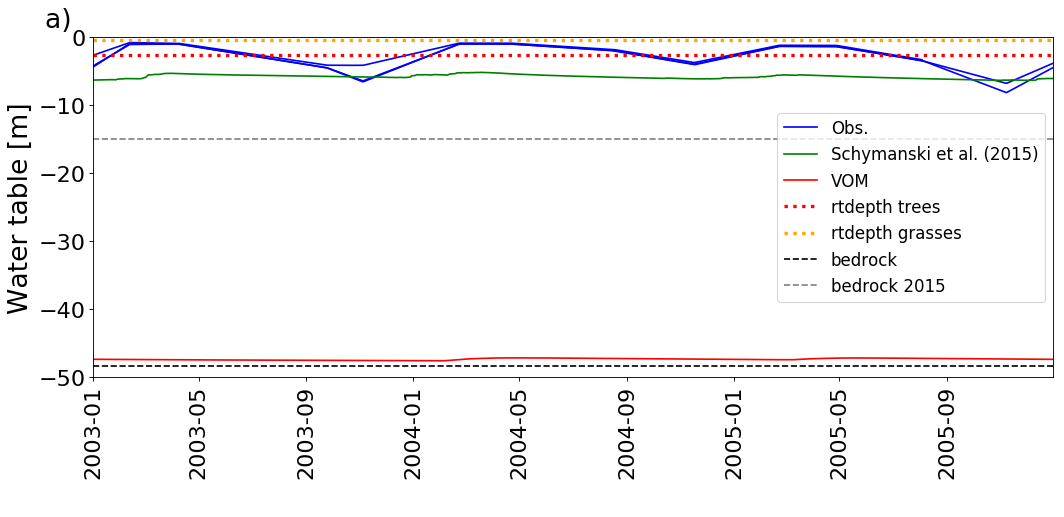

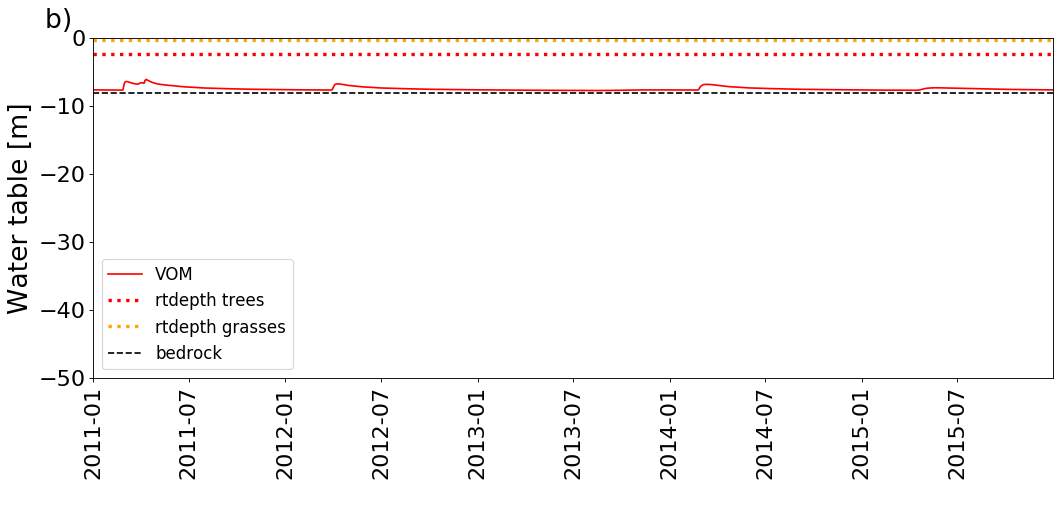

In [4]:
#plot groundwater tables
%run ../src_py/plot_gw.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
--i2015 ../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt\
--depth True -ys 2003 -ye 2005 \
--ylabel "Water table [m]"  \
--labels VOM \
--colors "red" \
--i_cz 48.40  \
--i_cz2015 15 \
--obs ../data/boreholes/RN030982.csv \
../data/boreholes/RN030983.csv \
../data/boreholes/RN030984.csv \
--pars ../work/HowardSprings/freedrainage_cpcff1.0/best/input/pars.txt \
--title "a) " --legend True --xloc_title -0.05 --size_title 24 \
--outputfile "../data/img/4a_gw_depths.png"

%run ../src_py/plot_gw.py  \
-i ../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt \
--depth True -ys 2011 -ye 2015 \
--ylabel "Water table [m]"  \
--labels VOM \
--colors "red" \
--i_cz 8.20  \
--pars ../work/AdelaideRiver/freedrainage_cpcff1.0/best/input/pars.txt \
--title "b) " --legend True --xloc_title -0.05 --size_title 24 \
--outputfile "../data/img/4b_gw_depths.png"



**Figure 4** Groundwater depths for a) Howard Springs and b) Adelaide River. Dashed lines represent the bedrock depth, dotted lines the rooting depths (trees in red and grasses in orange), the VOM-results are shown in blue, the results of Schymanski et al. (2009) in green.

## Costfactor for water transport

### Effect on timeseries

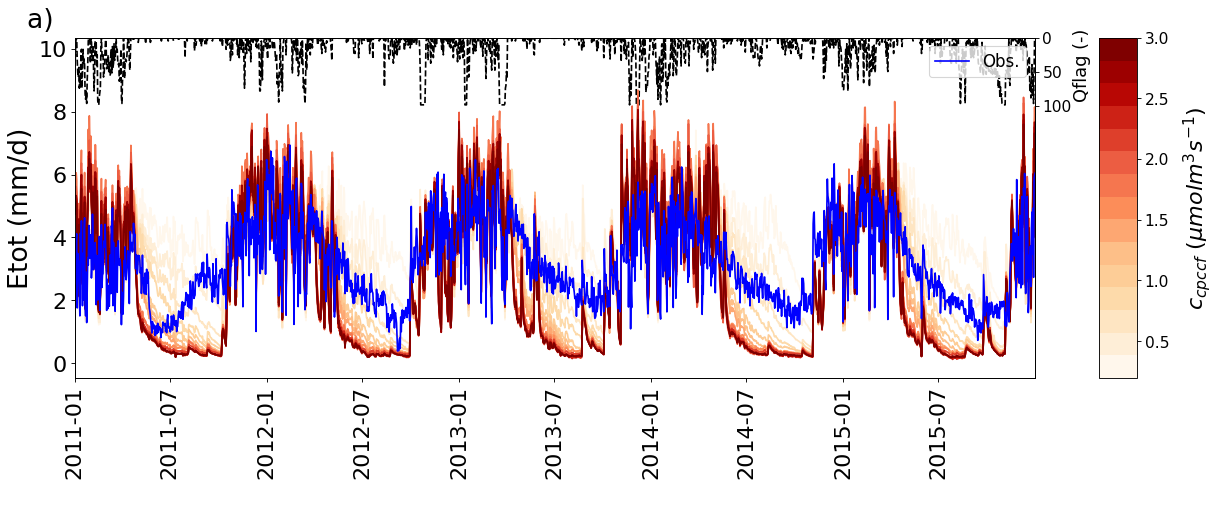

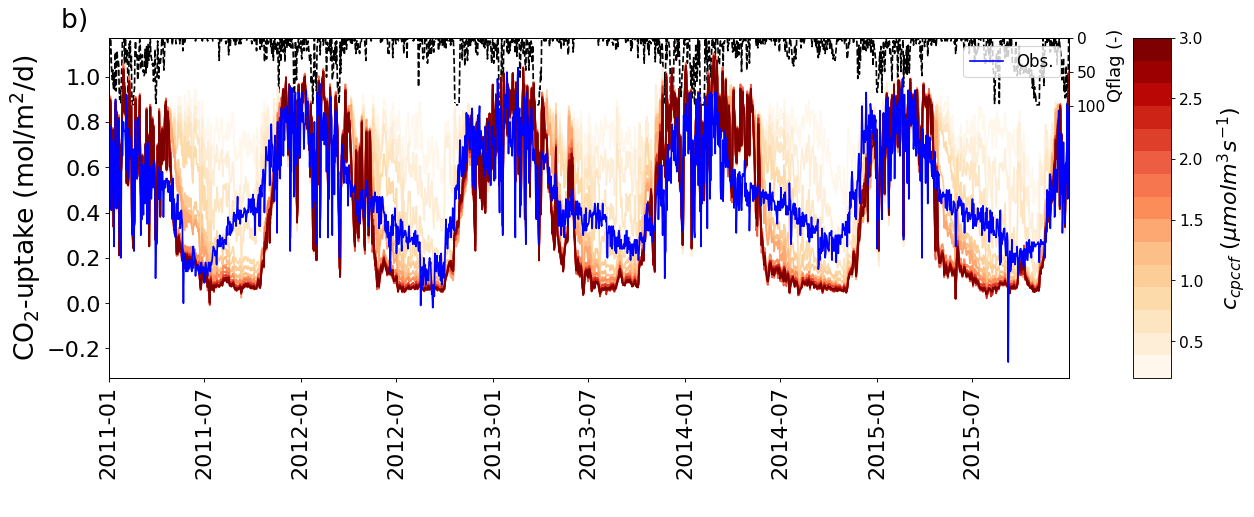

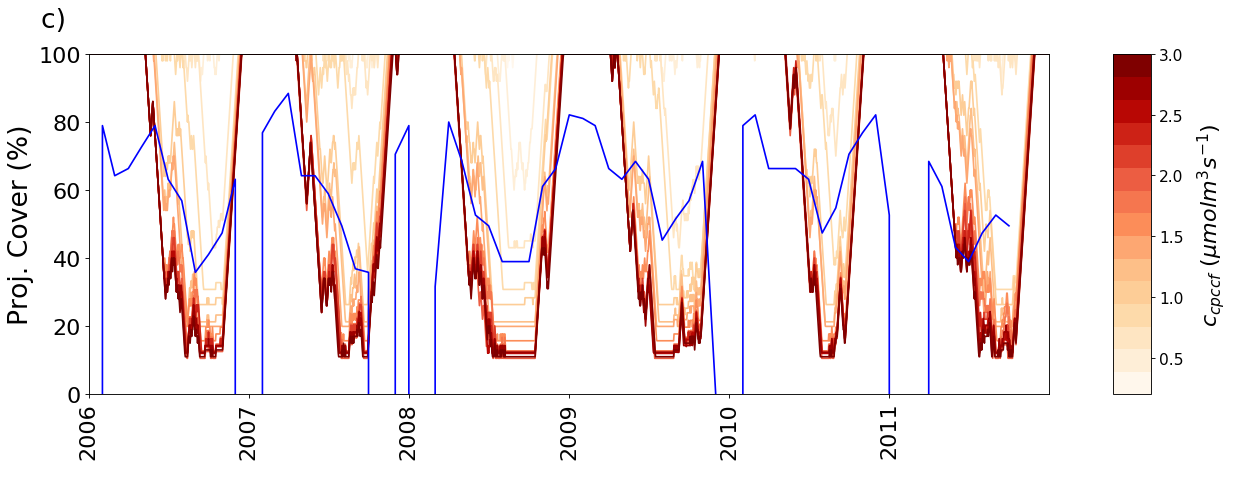

In [5]:
#HowardSprings
%run ../src_py/plot_et_ass.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff3.0/sce_best/results_daily.txt \
-v evaptot -ys 2011 -ye 2015 -w ../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot (mm/d)" --cbar_max 3.0 --legend True\
--plot_cbar True --cblabel "$c_{cpccf}$ ($\mu mol m^3 s^{-1})$" --labels VOM VOM2 --obs_qc ../data/DINGO_QC/FeQ_howard.txt \
--title "a) " --xloc_title -0.05 --size_title 24 --outputfile "../data/img/5a_hs_fluxes.png"

#HowardSprings
%run ../src_py/plot_et_ass.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff3.0/sce_best/results_daily.txt \
-v asstot -ys 2011 -ye 2015 -w ../data/VOM_input/HowardSprings/dailyweather.prn --obs_qc ../data/DINGO_QC/FcQ_howard.txt\
--obs ../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO$_2$-uptake (mol/m$^2$/d)" --cbar_max 3.0 \
--plot_cbar True --cblabel "$c_{cpccf}$ ($\mu mol m^3 s^{-1}) $" --labels VOM VOM2 \
--title "b) " --xloc_title -0.05 --size_title 24 --legend True\
--outputfile "../data/img/5b_hs_fluxes.png"

#HowardSprings
%run ../src_py/plot_vegetation.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff3.0/sce_best/results_daily.txt \
-v pc -ys 2006 -ye 2011 -w ../data/VOM_input/HowardSprings/dailyweather.prn --cbar_max 3.0 \
--obs ../data/fPAR/fpar_howard_v5.txt --obsdates ../data/fPAR/dates_v5 \
--ylabel "Proj. Cover (%)" --mf 100 \
--plot_cbar True --cblabel "$c_{cpccf}$ ($\mu mol m^3 s^{-1})$" --labels VOM VOM2 \
--title "c) " --xloc_title -0.05 --yloc_title 1.10 --size_title 24 \
--outputfile "../data/img/5c_hs_fluxes.png"


**Figure 5.** VOM-results for different values of the costfactor cpcff (color scale) for HowardSprings, with a) the total evaporation, with fluxtower observations in blue b) CO$_2$-assimilation, with fluxtower observations in blue and c) projective cover, with the observed fraction of vegetation cover based on fPar-data (Donohue et al., 2008).

### Selecting cost factors

No handles with labels found to put in legend.


<Figure size 1280x1040 with 0 Axes>

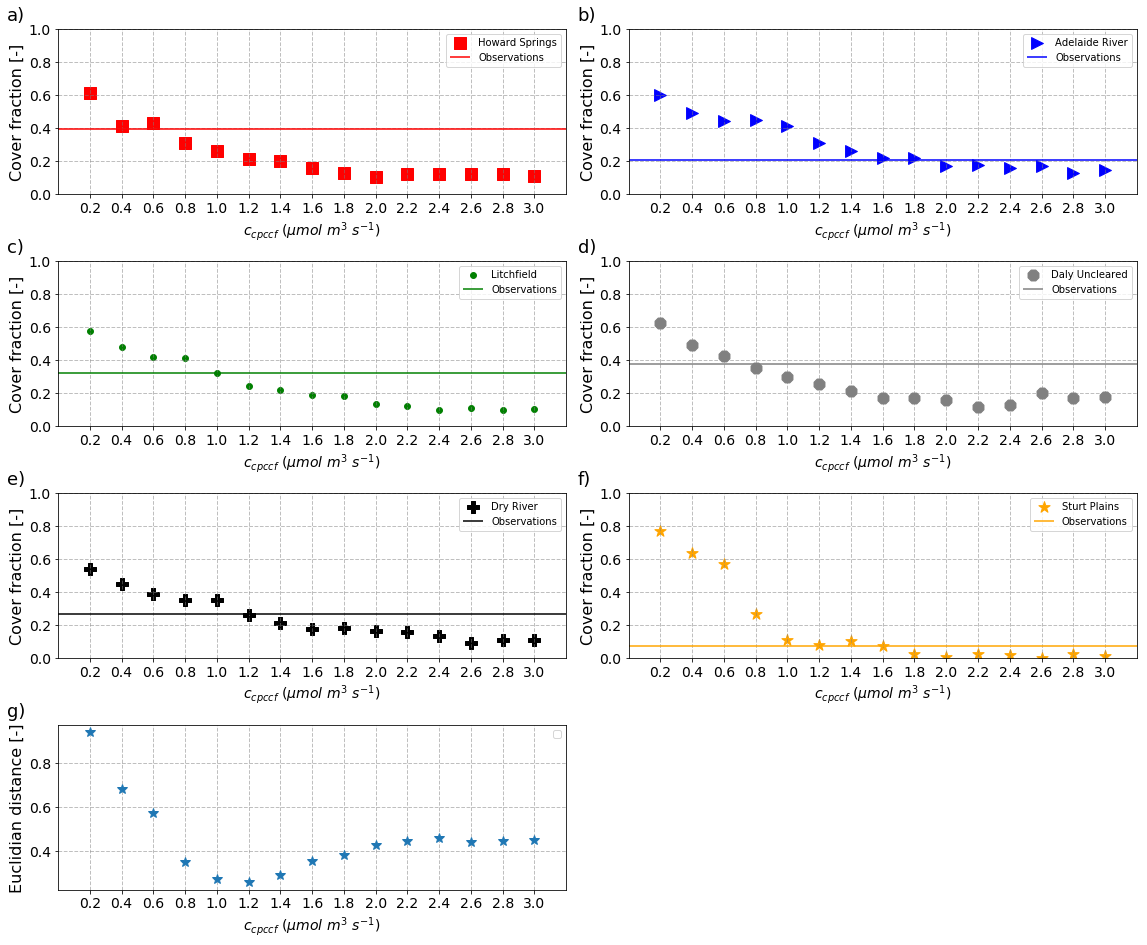

In [6]:
#plot parameters
cpcff_vals = np.arange(0.2,3.2, 0.2)
study_sites = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver", "SturtPlains" ]
site_name = ["Howard Springs", "Adelaide River", "Litchfield", "Daly Uncleared", "Dry River", "Sturt Plains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cai_fpar = [0.3971929824561404, #HowardSprings
0.20771929824561405, #AdelaideRiver
0.32000000000000006, #Litchfield
0.37473684210526315, #DalyUncleared
0.26616541353383455, #DryRiver
0.07443609022556391 #SturtPlains
] 

err = np.zeros((len(cpcff_vals),6))
ED = np.zeros((len(cpcff_vals)))

symbols = ['s', '>', '.','8', 'P','*']
colors = ['red', 'blue', 'green', 'gray', 'black', 'orange']
fig_lab = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']

fig=plt.figure(figsize=(16, 13), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 13)) 
fig.delaxes(axes[3,1])
ax = axes.flat


i_cpcff = 0
for cpcff in  cpcff_str:  
    ibasin = 0

    for site in study_sites:
        try:
            params = np.loadtxt("../work/"+  site  +"/freedrainage_cpcff" + cpcff +
                      "/best/input/pars.txt")

            cai = params[4]
                
            err[i_cpcff, ibasin] = cai - cai_fpar[ibasin]
                          
            if(i_cpcff ==0):
                ax[ibasin].scatter(cpcff_vals[i_cpcff], cai, marker=symbols[ibasin], color=colors[ibasin] , s=140, label=site_name[ibasin])     
                #ax[ibasin].plot(0.02, cai_fpar[ibasin], marker=symbols[ibasin], color=colors[ibasin] , markersize=8)     
                ax[ibasin].hlines( cai_fpar[ibasin], 0, 3.2, color = colors[ibasin],label = "Observations" )
                ax[ibasin].text(-0.10, 1.05, fig_lab[ibasin], transform=ax[ibasin].transAxes, size=18)
            else:
                ax[ibasin].scatter(cpcff_vals[i_cpcff], cai, marker=symbols[ibasin], color=colors[ibasin] , s=140)     

                
            ax[ibasin].set_ylabel("Cover fraction [-]", size=16 )  
            ax[ibasin].set_ylim( 0, 1  ) 
            ax[ibasin].set_xlim( 0, 3.2  )    

            ax[ibasin].legend(prop={'size':10})
            #if(ibasin > 3):
                #ax[ibasin].set_xlabel("cpcff [-]", size=16 )  
            ax[ibasin].set_xlabel(r'$c_{cpccf}$ ($\mu$$mol$ $m^3$ $s^{-1}$)', size=14 )  

            
            #ax[0].text(-0.07, 1.02, "a)", transform=ax[0].transAxes, 
            #            size=20, weight='bold')
            ax[ibasin].tick_params(axis='both', which='major', labelsize=14)
            ax[ibasin].set_xticks(cpcff_vals)
            ax[ibasin].set_xticklabels(cpcff_str)
            ax[ibasin].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)

                
                
        except OSError:
            print('file not found')
        ibasin = ibasin + 1 
    i_cpcff = i_cpcff + 1
    
#combining the errors
for i_cpcff in range(len(cpcff_str)):
    ED[i_cpcff] = np.sqrt(np.sum(err[i_cpcff,:]**2))

ax[6].plot(cpcff_vals, ED, "*", markersize=10)
ax[6].set_ylabel("Euclidian distance [-]", size = 16 )  
#ax[1].set_ylim( 1, 9  )
ax[6].set_xlim( 0, 3.2  )    

ax[6].legend(prop={'size':10})
ax[6].text(-0.10, 1.05, fig_lab[ibasin], transform=ax[6].transAxes, 
            size=18)
ax[6].tick_params(axis='both', which='major', labelsize=14)
ax[6].set_xticks(cpcff_vals)
ax[6].set_xticklabels(cpcff_str)
ax[6].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax[6].set_xlabel(r'$c_{cpccf}$ ($\mu$$mol$ $m^3$ $s^{-1}$)', size=14 )  

plt.savefig("../data/img/6_cpcff.png",bbox_inches = "tight")
plt.tight_layout() 
plt.show()




**Figure 6.** Costfactor for the watertransport system (cpccf) versus the percentage vegetation cover in the dry season for the different sites a)-f) with modelled fraction of vegetation cover (symbols) and the for observed fraction of vegetation cover (line) based on fPar-data \citep{donohue_deriving_2008} and b) Euclidean distance based on the error for all six study sites between observed and modelled vegetation fractions for each cpcff-value, i.e. $ED =  \sqrt{ \sum_{i=1}^{n} E_{i}^2    }$, with $E_{i}$ the error for each site.


Conclusion:
- Optimal costfactor highly variable along the transect.
- Relations with other factors, such as temperatures, droughts, etc. needs to be investigated.


### Costfactor and climate indeces

In [7]:
def mean_annual(inputfile, var ,startyear, endyear, method):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data[var]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['fyear'][0]),int(data['fmonth'][0]),int(data['fday'][0])), 
                      datetime(int(data['fyear'][-1]),int(data['fmonth'][-1]),int(data['fday'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
                    
    if(method == "sum"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').sum() ) 
    if(method == "max"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').max() ) 
    if(method == "min"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').min() )

    
    return vals_ma      
                

In [8]:
prec_howard = mean_annual("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_litch = mean_annual("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_ade = mean_annual("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_daly = mean_annual("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_dry = mean_annual("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_sturt = mean_annual("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")

prec_all = [prec_howard, prec_litch, prec_ade, prec_daly, prec_dry, prec_sturt  ]

In [9]:
tmax_howard = mean_annual("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_litch = mean_annual("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_ade = mean_annual("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_daly = mean_annual("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_dry = mean_annual("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_sturt = mean_annual("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")

tmax_all = [tmax_howard, tmax_litch, tmax_ade, tmax_daly, tmax_dry, tmax_sturt  ]

In [10]:
def calc_netrad( weatherdata_file, lat, startyear, endyear ):
    
    #calculate net radiation, following FAO

    weatherdata = np.genfromtxt(weatherdata_file, names=True  )    
    
    #constants
    sigma = 4.903*10**-9 #Stefan-Boltzman constant [MJ K-4 m-2 day-1]
    Gsc = 0.0820 #solar constant [MJ m-2 hour-1]
    n = 10 #220/31 #sunshine hours
    N = 10 #maximum sunshine hours
    
    #get data from VOM-dailyweather
    Rs = weatherdata["Radn"]    # incoming solar radiation [MJ m-2 day-1]
    Tmax = weatherdata["TMax"]  # Celsius
    Tmin = weatherdata["TMin"]  # Celsius
    ea = weatherdata["VP"] /10  # kPa

    #define time and dates
    time = np.arange(datetime(int(weatherdata['Year'][0]),int(weatherdata['Month'][0]),int(weatherdata['Day'][0])), 
                  datetime(int(weatherdata['Year'][-1]),int(weatherdata['Month'][-1]),int(weatherdata['Day'][-1]))+timedelta(days=1), 
                  timedelta(days=1)).astype(datetime)
    time_pd = pd.date_range(time[0],periods=len( time ), freq='D')

    #day of year
    J = time_pd.dayofyear
    
    #inverse relative distance Earth-Sun
    dr =  1 + 0.033*np.cos(2*np.pi*J/365)  # [m?]

    phi=  (np.pi/180) * lat   #latitude [rad]
    
    #solar declination
    delta= 0.409*np.sin( (2*J*np.pi/365)  - 1.39 ) #[rad]
    
    #sunset hour angle
    ws =  np.arccos(-np.tan(phi)*np.tan(delta))

    #extraterrestrial radiation
    part1 = (24*60/np.pi) * Gsc * dr 
    part2 = ws*np.sin(phi)*np.sin(delta)
    part3 = np.cos(phi)*np.cos(delta)*np.sin(ws) 

    Ra =  part1*(part2+part3)  #[MJ m-2 hr-1]


    #Rso = Ra*z*0.75*2*10**-5
    Rso = Ra*(0.25+0.5*(n/N)) #clear-sky solar radiation [MJ m-2 day-1]

    Rns = (1-0.23) * Rs # shortwave radiation

    part1 = sigma*((Tmax+273.16)**4 + (Tmin+273.16)**4)/2
    part2 = 0.34-0.14*np.sqrt(ea)
    part3 = 1.35*Rs/Rso -0.35

    Rnl = part1 * part2 * part3 #net longwave radiation [MJ m-2 day-1]

    Rn = Rns - Rnl
    
    Rn_pd = pd.Series(Rn, index = time_pd)
    Rn_pd = Rn_pd[ (Rn_pd.index.year>=startyear) & (Rn_pd.index.year<=endyear)]
    
    return Rn_pd

In [11]:
def aridity(rn, input_vom, startyear, endyear):
       
    
    #input: results vom
    #precipitation
    #potential evaporation
    #net radiation
    
    weatherdata = np.genfromtxt(input_vom, names=True  )

    #define time and dates
    time = np.arange(datetime(int(weatherdata['Year'][0]),int(weatherdata['Month'][0]),int(weatherdata['Day'][0])), 
                  datetime(int(weatherdata['Year'][-1]),int(weatherdata['Month'][-1]),int(weatherdata['Day'][-1]))+timedelta(days=1), 
                  timedelta(days=1)).astype(datetime)
    time_pd = pd.date_range(time[0],periods=len( time ), freq='D')
    
    
    lat_heat_vapor = 2.45   #[MJ/kg] 
    rho_w = 1000             #[kg/m3]

    prec = pd.Series(weatherdata['Rain'], index=time_pd)
    prec = prec[ (prec.index.year>=startyear) & (prec.index.year<=endyear)]
    #rn = np.array(rn)  
    ep = 1000*rn/(lat_heat_vapor*rho_w) #mm/d
    Lp = prec * lat_heat_vapor 
    
    
    #in terms of water, prec as base
    EpP = np.sum(ep) / np.sum(prec) 
        
    #in terms of energy  
    RnLp = np.sum(rn) / np.sum(Lp) #same as Ep/P    

    return EpP, RnLp


In [12]:
rn_howard = calc_netrad("../data/VOM_input/HowardSprings/dailyweather.prn", -12.5,1995, 2015)
rn_litch = calc_netrad("../data/VOM_input/Litchfield/dailyweather.prn", -13.1790,1995, 2015)
rn_ade = calc_netrad("../data/VOM_input/AdelaideRiver/dailyweather.prn", -13.077,1995, 2015)
rn_daly = calc_netrad("../data/VOM_input/DalyUncleared/dailyweather.prn", -14.1592,1995, 2015)
rn_dry = calc_netrad("../data/VOM_input/DryRiver/dailyweather.prn", -15.2587833333333 ,1995, 2015)
rn_sturt = calc_netrad("../data/VOM_input/SturtPlains/dailyweather.prn", -17.1507,1995, 2015)

aridity_howard = aridity(rn_howard, "../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015)
aridity_litch = aridity(rn_litch, "../data/VOM_input/Litchfield/dailyweather.prn",1995, 2015)
aridity_ade = aridity(rn_ade, "../data/VOM_input/AdelaideRiver/dailyweather.prn",1995, 2015)
aridity_daly = aridity(rn_daly, "../data/VOM_input/DalyUncleared/dailyweather.prn",1995, 2015)
aridity_dry = aridity(rn_dry, "../data/VOM_input/DryRiver/dailyweather.prn",1995, 2015)
aridity_sturt = aridity(rn_sturt, "../data/VOM_input/SturtPlains/dailyweather.prn",1995, 2015)

aridity = [aridity_howard, aridity_litch, aridity_ade, aridity_daly, aridity_dry, aridity_sturt ]

In [13]:
startyear = 1995
endyear = 2015

rn_howard_ma = np.mean(rn_howard[ (rn_howard.index.year>=startyear) & (rn_howard.index.year<=endyear)].resample('A').sum() ) 
rn_litch_ma = np.mean(rn_litch[ (rn_litch.index.year>=startyear) & (rn_litch.index.year<=endyear)].resample('A').sum() ) 
rn_ade_ma = np.mean(rn_ade[ (rn_ade.index.year>=startyear) & (rn_ade.index.year<=endyear)].resample('A').sum() ) 
rn_daly_ma = np.mean(rn_daly[ (rn_daly.index.year>=startyear) & (rn_daly.index.year<=endyear)].resample('A').sum() ) 
rn_dry_ma = np.mean(rn_dry[ (rn_dry.index.year>=startyear) & (rn_dry.index.year<=endyear)].resample('A').sum() ) 
rn_sturt_ma = np.mean(rn_sturt[ (rn_sturt.index.year>=startyear) & (rn_sturt.index.year<=endyear)].resample('A').sum() ) 

rn_ma = [rn_howard_ma, rn_litch_ma, rn_ade_ma, rn_daly_ma, rn_dry_ma, rn_sturt_ma ]

In [14]:
def rainfall_seasonality(inputfile,startyear, endyear):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data["Rain"]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['Year'][0]),int(data['Month'][0]),int(data['Day'][0])), 
                      datetime(int(data['Year'][-1]),int(data['Month'][-1]),int(data['Day'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
    vals_pd = vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)]
    Pma = np.mean(vals_pd.resample('A').sum() ) 

    Pmm = np.zeros(12) #mean monthly rainfall
    for i in range(1,13):
        Pmm_tmp = np.mean(vals_pd[vals_pd.index.month == i])
        Pmm[i-1] = Pmm_tmp
    
        
    seasonality =  (1/Pma) * np.sum( np.abs(Pmm - (Pma / 12)) )
        
    return seasonality      
                

In [15]:
seas_howard = rainfall_seasonality("../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015)
seas_litch = rainfall_seasonality("../data/VOM_input/Litchfield/dailyweather.prn", 1995, 2015)
seas_ade = rainfall_seasonality("../data/VOM_input/AdelaideRiver/dailyweather.prn", 1995, 2015)
seas_daly = rainfall_seasonality("../data/VOM_input/DalyUncleared/dailyweather.prn", 1995, 2015)
seas_dry = rainfall_seasonality("../data/VOM_input/DryRiver/dailyweather.prn" ,1995, 2015)
seas_sturt = rainfall_seasonality("../data/VOM_input/SturtPlains/dailyweather.prn", 1995, 2015)

seas = [seas_howard, seas_litch, seas_ade, seas_daly, seas_dry, seas_sturt ]


In [16]:
def dry_season(inputfile,startyear, endyear):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data["Rain"]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['Year'][0]),int(data['Month'][0]),int(data['Day'][0])), 
                      datetime(int(data['Year'][-1]),int(data['Month'][-1]),int(data['Day'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
    vals_pd = vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)]
    
    

    dry_period = np.zeros( len(np.arange(startyear,endyear+1))) #yearly dry periods
    i = 0
    for iyear in np.arange(startyear,endyear+1):
        tmp = vals_pd[vals_pd.index.year == iyear]
        dry_period[i] = tmp.value_counts().max()
        i = i + 1
    
        
    dryseason_duration =  np.mean(dry_period)
        
    return dryseason_duration      
                

In [17]:
drydur_howard = dry_season("../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015)
drydur_litch = dry_season("../data/VOM_input/Litchfield/dailyweather.prn", 1995, 2015)
drydur_ade = dry_season("../data/VOM_input/AdelaideRiver/dailyweather.prn", 1995, 2015)
drydur_daly = dry_season("../data/VOM_input/DalyUncleared/dailyweather.prn", 1995, 2015)
drydur_dry = dry_season("../data/VOM_input/DryRiver/dailyweather.prn" ,1995, 2015)
drydur_sturt = dry_season("../data/VOM_input/SturtPlains/dailyweather.prn", 1995, 2015)

drydur = [drydur_howard, drydur_litch, drydur_ade, drydur_daly, drydur_dry, drydur_sturt  ]


In [18]:
#determine best cpcff
cpcff_vals = np.arange(0.2,2.8, 0.2)
study_sites = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver", "SturtPlains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cai_fpar = [0.3971929824561404, #HowardSprings
0.20771929824561405, #AdelaideRiver
0.32000000000000006, #Litchfield
0.37473684210526315, #DalyUncleared
0.26616541353383455, #DryRiver
0.07443609022556391 #SturtPlains
] 

err = np.zeros((len(cpcff_vals),6))
cpcff_best = np.zeros(6)


ibasin = 0
for site in study_sites:

    i_cpcff = 0
    

    for cpcff in  cpcff_str: 
        try:
            params = np.loadtxt("../work/"+  site  +"/freedrainage_cpcff" + cpcff +
                      "/best/input/pars.txt")

            cai = params[4]              
            err[i_cpcff, ibasin] = np.abs(cai - cai_fpar[ibasin])
            
        except OSError:
            print('file not found')
         
        i_cpcff = i_cpcff + 1
        
        
    cpcff_best[ibasin] = cpcff_vals[err[:,ibasin] == min(err[:,ibasin])]
    ibasin = ibasin + 1    

<Figure size 1280x400 with 0 Axes>

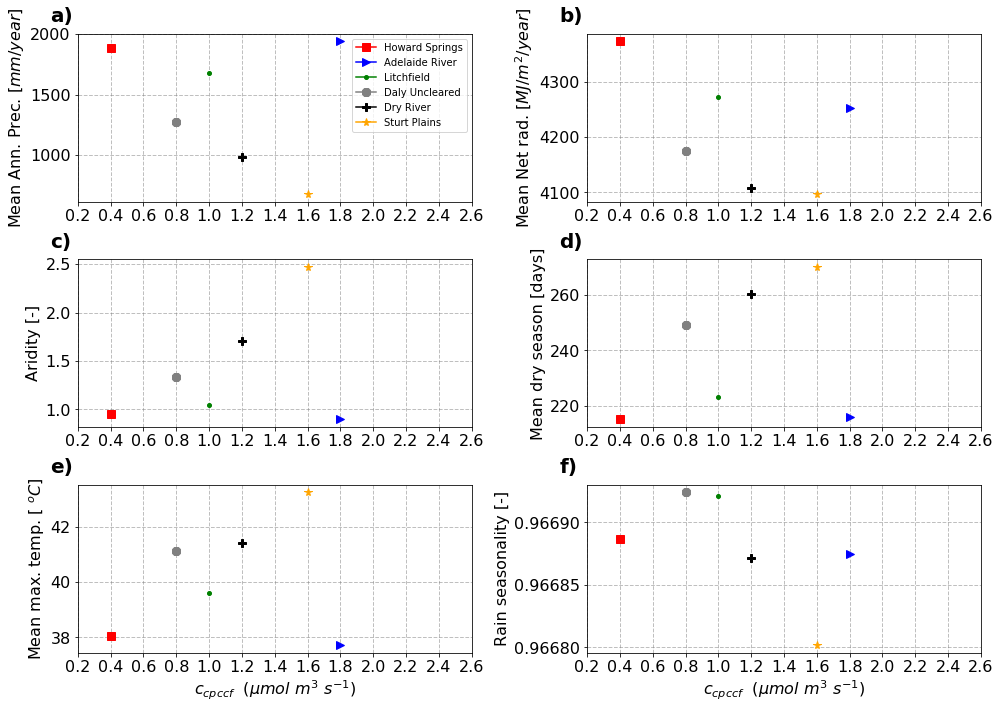

In [19]:
#plot parameters
cpcff_vals = np.arange(0.2,2.8, 0.2)
study_sites = ["Howard Springs", "Adelaide River", "Litchfield", "Daly Uncleared", "Dry River", "Sturt Plains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cai_fpar = [0.3971929824561404, #HowardSprings
0.20771929824561405, #AdelaideRiver
0.32000000000000006, #Litchfield
0.37473684210526315, #DalyUncleared
0.26616541353383455, #DryRiver
0.07443609022556391 #SturtPlains
] 

err = np.zeros((len(cpcff_vals),6))
ED = np.zeros((len(cpcff_vals)))

symbols = ['s', '>', '.','8', 'P','*']
colors = ['red', 'blue', 'green', 'gray', 'black', 'orange']

ylabel = ["Mean Ann. Prec. [$mm/year$]",
          r"Mean Net rad. [$MJ/m^{2}/year$]",
          "Aridity [-]",
          "Mean dry season [days]",
          "Mean max. temp. [ $^o C$]",
          "Rain seasonality [-]"        
         ]

fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10)) 
ax = axes.flat

isite = 0

for site in study_sites:


    ax[0].plot(cpcff_best[isite], prec_all[isite], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     
    ax[1].plot(cpcff_best[isite], rn_ma[isite], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     
    ax[2].plot(cpcff_best[isite], aridity[isite][1], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     
    ax[3].plot(cpcff_best[isite], drydur[isite], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     
    ax[4].plot(cpcff_best[isite], tmax_all[isite], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     
    ax[5].plot(cpcff_best[isite], seas[isite], marker=symbols[isite], color=colors[isite] , markersize=8, label=site_name[isite])     

    isite = isite + 1

    
ax[0].legend(prop={'size':10})

for i in range(0,6):
    ax[i].set_ylabel(ylabel[i], size=16 )  
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    ax[i].set_xticks(cpcff_vals)
    ax[i].set_xticklabels(cpcff_str)
    ax[i].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax[i].tick_params(axis='both', which='major', labelsize=16)

ax[4].set_xlabel(r'$c_{cpccf}$  ($\mu$$mol$ $m^3$ $s^{-1}$)', size=16 )  
ax[5].set_xlabel(r'$c_{cpccf}$  ($\mu$$mol$ $m^3$ $s^{-1}$)', size=16 )  


ax[0].text(-0.07, 1.07, "a)", transform=ax[0].transAxes,  size=20, weight='bold')
ax[1].text(-0.07, 1.07, "b)", transform=ax[1].transAxes,  size=20, weight='bold')
ax[2].text(-0.07, 1.07, "c)", transform=ax[2].transAxes,  size=20, weight='bold')
ax[3].text(-0.07, 1.07, "d)", transform=ax[3].transAxes,  size=20, weight='bold')
ax[4].text(-0.07, 1.07, "e)", transform=ax[4].transAxes,  size=20, weight='bold')
ax[5].text(-0.07, 1.07, "f)", transform=ax[5].transAxes,  size=20, weight='bold')

plt.tight_layout()
    
plt.savefig("../data/img/7_cpcff_climate.png", bbox_inches = "tight")
plt.show()


**Figure 7.** Selected costfactor for the watertransport system (cpcff) for each study site versus several climatic indeces, with a) mean annual precipitation, b) mean net radiation, c) aridity, d) mean length of the dry season, e) mean maximum temperature and f) mean rainfall seasonality.

## Foliage costs

### Effect on timeseries

/home/remko/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


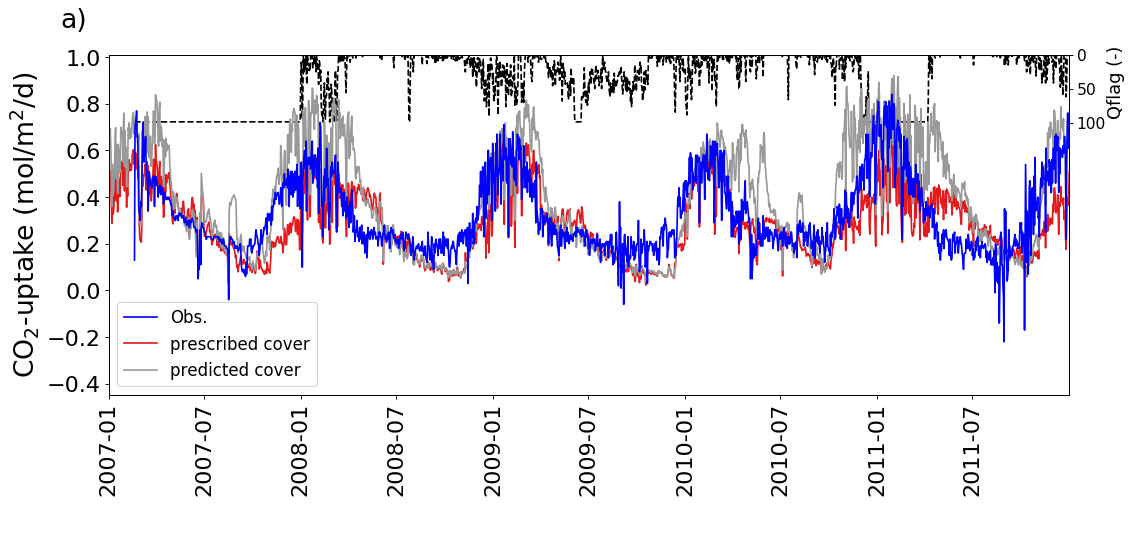

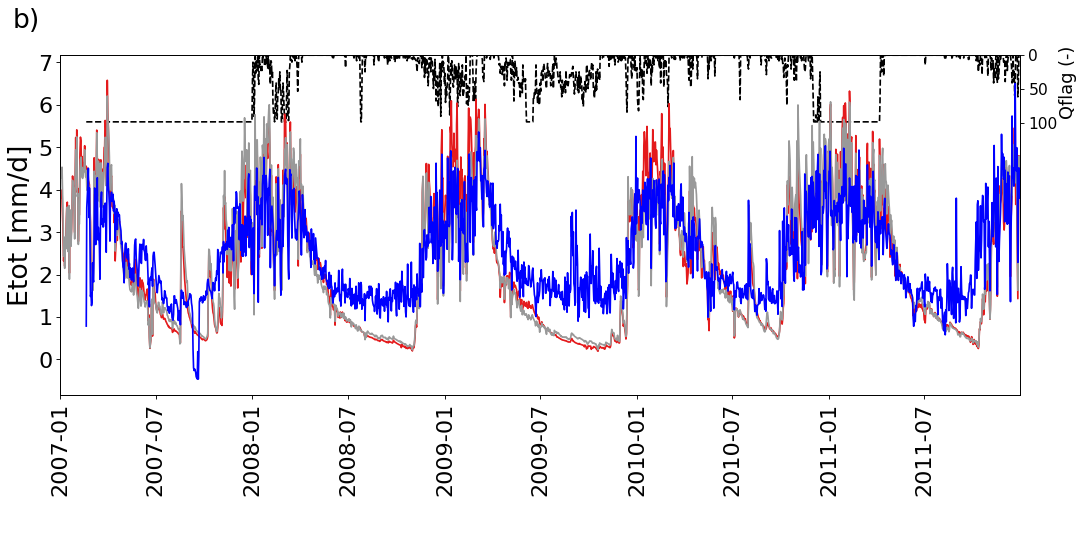

In [20]:
#DalyUncleared
%run ../src_py/plot_et_ass.py  \
-i ../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_best/results_daily.txt \
../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt \
-v asstot -ys 2007 -ye 2011 -w ../data/VOM_input/DalyUncleared/dailyweather.prn \
--obs ../data/DINGO/GPPdaily_daly.txt --mf_obs -1 --ylabel "CO$_2$-uptake (mol/m$^2$/d)" \
--labels "prescribed cover" "predicted cover" --title "a)" --legend True  \
--palette Set1 --xloc_title -0.05 --yloc_title 1.10  --size_title 24 \
--obs_qc ../data/DINGO_QC/FcQ_daly.txt \
--outputfile "../data/img/8a_pc_daly.png"

#DalyUncleared
%run ../src_py/plot_et_ass.py  \
-i ../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_best/results_daily.txt \
../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt \
-v evaptot -ys 2007 -ye 2011 -w ../data/VOM_input/DalyUncleared/dailyweather.prn \
--obs ../data/DINGO/Ea_daly.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "prescribed cover" "free-draining" "dynamic watertables" --title "b)"   \
--palette Set1 --xloc_title -0.05 --yloc_title 1.10 --size_title 24 \
--obs_qc ../data/DINGO_QC/FeQ_daly.txt \
--outputfile "../data/img/8b_pc_daly.png"


**Figure 8.** Comparison between the VOM with prescribed and predicted vegetation cover, for a) assimilation and b) evaporation, with model results obtained by the prescribed cover in red, the predicted cover in grey and the fluxtower observations in blue.

### Flux partitioning

In [21]:
def fluxpartitions(inputfile, startyear, endyear):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    esoil = 1000*np.array(data["esoil"]) #mm/d
    etmt = 1000*np.array(data["etmt"])   #mm/d
    etmg = 1000*np.array(data["etmg"])   #mm/d
    assg = np.array(data["assg"])        #mol/m2/d
    asst = np.array(data["asst"])        #mol/m2/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['fyear'][0]),int(data['fmonth'][0]),int(data['fday'][0])), 
                      datetime(int(data['fyear'][-1]),int(data['fmonth'][-1]),int(data['fday'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    esoil_pd = pd.Series(esoil, index=tmod)
    etmt_pd = pd.Series(etmt, index=tmod)
    etmg_pd = pd.Series(etmg, index=tmod)
    assg_pd = pd.Series(assg, index=tmod)
    asst_pd = pd.Series(asst, index=tmod)
                    
    esoil_ma = np.mean(esoil_pd[ (esoil_pd.index.year>=startyear) & (esoil_pd.index.year<=endyear)].resample('A').sum() ) 
    etmt_ma = np.mean(etmt_pd[(etmt_pd.index.year>=startyear) & (etmt_pd.index.year<=endyear)].resample('A').sum() ) 
    etmg_ma = np.mean(etmg_pd[(etmg_pd.index.year>=startyear) & (etmg_pd.index.year<=endyear)].resample('A').sum() ) 
    assg_ma = np.mean(assg_pd[(assg_pd.index.year>=startyear) & (assg_pd.index.year<=endyear)].resample('A').sum() ) 
    asst_ma = np.mean(asst_pd[(asst_pd.index.year>=startyear) & (asst_pd.index.year<=endyear)].resample('A').sum() ) 

    result = [esoil_ma, etmt_ma, etmg_ma, assg_ma, asst_ma]
                    
    return result      
                

In [22]:
def mean_annual_dingo(inputfile, startyear, endyear):

    #load data
    
    data = np.loadtxt(inputfile, usecols=2) #mm/d
    
    #create series of pandas time
    tflux_tmp = np.genfromtxt(inputfile, usecols=0, dtype=np.str )#mm/d
    tflux = pd.date_range(tflux_tmp[0], tflux_tmp[-1], freq='D')
                    
    #make pandas series
    vals_pd = pd.Series(data, index=tflux)                    
    vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').sum() ) 
                    
    return vals_ma      
                

In [23]:

Ea_howard_obs = mean_annual_dingo("../data/DINGO/Ea_howard.txt", 2002, 2017)
Ea_litch_obs = mean_annual_dingo("../data/DINGO/Ea_litch.txt", 2016, 2018)
Ea_adelaide_obs = mean_annual_dingo("../data/DINGO/Ea_adelaide.txt",  2007, 2008)
Ea_daly_obs = mean_annual_dingo("../data/DINGO/Ea_daly.txt", 2008, 2017)
Ea_dry_obs = mean_annual_dingo("../data/DINGO/Ea_dry.txt", 2009, 2017)
Ea_sturt_obs = mean_annual_dingo("../data/DINGO/Ea_sturt.txt", 2009, 2017)

etot_dingo = [Ea_howard_obs, Ea_litch_obs, Ea_adelaide_obs, Ea_daly_obs, Ea_dry_obs,Ea_sturt_obs    ]

In [24]:
GPP_howard_obs = mean_annual_dingo("../data/DINGO/GPPdaily_howard.txt", 2002, 2017)* -1.0
GPP_litch_obs = mean_annual_dingo("../data/DINGO/GPPdaily_litch.txt", 2016, 2018)* -1.0
GPP_adelaide_obs = mean_annual_dingo("../data/DINGO/GPPdaily_adelaide.txt", 2007, 2008)* -1.0
GPP_daly_obs = mean_annual_dingo("../data/DINGO/GPPdaily_daly.txt", 2008, 2017)* -1.0
GPP_dry_obs = mean_annual_dingo("../data/DINGO/GPPdaily_dry.txt", 2009, 2017)* -1.0
GPP_sturt_obs =mean_annual_dingo("../data/DINGO/GPPdaily_sturt.txt", 2009, 2017) * -1.0

gpptot_dingo = [GPP_howard_obs, GPP_litch_obs, GPP_adelaide_obs,GPP_daly_obs, GPP_dry_obs, GPP_sturt_obs  ] 

In [25]:
#mean annual fluxes for predicted cover
ma_howard_dingo = fluxpartitions("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", 1995, 2015)
ma_litch_dingo = fluxpartitions("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", 1995, 2015)
ma_adelaide_dingo= fluxpartitions("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_daly_dingo = fluxpartitions("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_dry_dingo = fluxpartitions("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_sturt_dingo = fluxpartitions("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)


In [26]:
#mean annual fluxes for predicted cover
ma_howard = fluxpartitions("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", 1995, 2015)
ma_litch = fluxpartitions("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", 1995, 2015)
ma_adelaide= fluxpartitions("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_daly = fluxpartitions("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_dry = fluxpartitions("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)
ma_sturt = fluxpartitions("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt",1995, 2015)


In [27]:
#mean annual fluxes for prescribed cover
ma_howard_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/HowardSprings/sce_best/results_daily.txt", 1995, 2015)
ma_litch_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/Litchfield/sce_best/results_daily.txt",1995, 2015)
ma_adelaide_pc= fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/AdelaideRiver/sce_best/results_daily.txt",1995, 2015)
ma_daly_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_best/results_daily.txt",1995, 2015)
ma_dry_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/DryRiver/sce_best/results_daily.txt",1995, 2015)
ma_sturt_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/SturtPlains/sce_best/results_daily.txt",1995, 2015)


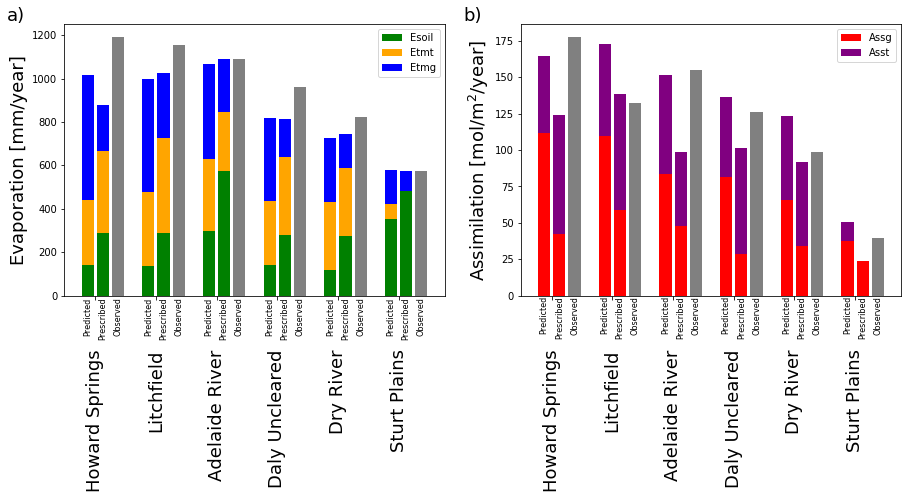

In [28]:

ind = np.arange(0,24, 4)
ind2 = ind + 1
ind3 = ind2 + 1

esoil_ma = [ma_howard[0], ma_litch[0], ma_adelaide[0], ma_daly[0], ma_dry[0], ma_sturt[0]]
etmt_ma = [ma_howard[1], ma_litch[1], ma_adelaide[1], ma_daly[1], ma_dry[1], ma_sturt[1]]
etmg_ma = [ma_howard[2], ma_litch[2], ma_adelaide[2], ma_daly[2], ma_dry[2], ma_sturt[2]]
assg_ma = [ma_howard[3], ma_litch[3], ma_adelaide[3], ma_daly[3], ma_dry[3], ma_sturt[3]]
asst_ma = [ma_howard[4], ma_litch[4], ma_adelaide[4], ma_daly[4], ma_dry[4], ma_sturt[4]]


esoil_ma_pc = [ma_howard_pc[0], ma_litch_pc[0], ma_adelaide_pc[0], ma_daly_pc[0], ma_dry_pc[0], ma_sturt_pc[0]]
etmt_ma_pc = [ma_howard_pc[1], ma_litch_pc[1], ma_adelaide_pc[1], ma_daly_pc[1], ma_dry_pc[1], ma_sturt_pc[1]]
etmg_ma_pc = [ma_howard_pc[2], ma_litch_pc[2], ma_adelaide_pc[2], ma_daly_pc[2], ma_dry_pc[2], ma_sturt_pc[2]]
assg_ma_pc = [ma_howard_pc[3], ma_litch_pc[3], ma_adelaide_pc[3], ma_daly_pc[3], ma_dry_pc[3], ma_sturt_pc[3]]
asst_ma_pc = [ma_howard_pc[4], ma_litch_pc[4], ma_adelaide_pc[4], ma_daly_pc[4], ma_dry_pc[4], ma_sturt_pc[4]]

fig, ax   = plt.subplots(nrows=1, ncols=2, figsize=(15, 5) )

p1 = ax[0].bar(ind, esoil_ma, color="green")
p2 = ax[0].bar(ind, etmt_ma, bottom=esoil_ma, color="orange")
p3 = ax[0].bar(ind, etmg_ma, bottom=np.add(etmt_ma,esoil_ma),color="blue")

p4 = ax[0].bar(ind2, esoil_ma_pc, color="green")
p5 = ax[0].bar(ind2, etmt_ma_pc, bottom=esoil_ma_pc, color="orange")
p6 = ax[0].bar(ind2, etmg_ma_pc, bottom=np.add(etmt_ma_pc,esoil_ma_pc), color="blue")

p7 = ax[0].bar(ind3, etot_dingo, color="grey")


ax[0].set_ylabel(r'Evaporation [mm/year]', fontsize=18)
ax[0].set_xticks(ind+0.5) 
ax[0].tick_params(axis="x", pad = 50)
ax[0].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18)
ax[0].legend((p1[0], p2[0], p3[0]), ('Esoil', 'Etmt', 'Etmg'))

ax[0].text(-0.15, 1.01, "a)", transform=ax[0].transAxes, 
            size=18)

for loc in ind:
    ax[0].text(loc, -40, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[0].text(loc, -40, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[0].text(loc, -40, "Observed", size=8, rotation=90, horizontalalignment='center')
    
p1 = ax[1].bar(ind, assg_ma, color="red")
p2 = ax[1].bar(ind, asst_ma, bottom=assg_ma, color="purple")

p4 = ax[1].bar(ind2, assg_ma_pc, color="red")
p5 = ax[1].bar(ind2, asst_ma_pc, bottom=assg_ma_pc, color="purple")

p6 = ax[1].bar(ind3, gpptot_dingo, color="grey")

for loc in ind:
    ax[1].text(loc, -5, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[1].text(loc, -5, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[1].text(loc, -5, "Observed", size=8, rotation=90, horizontalalignment='center')
     
    
ax[1].set_ylabel(r'Assimilation [mol/m$^2$/year]', fontsize=18)
ax[1].set_xticks(ind+0.5) 
ax[1].tick_params(axis="x",pad = 50)
ax[1].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18 )
ax[1].legend((p1[0], p2[0]), ('Assg', 'Asst'))

ax[1].text(-0.15, 1.01, "b)", transform=ax[1].transAxes, size=18)

plt.savefig("../data/img/9_fluxpartitioning.png", bbox_inches = "tight")
plt.show()

**Figure 9.** Partitioning of the fluxes for a) evaporation, with soil evaporation (green), tree transpiration (orange) and grass transpiration (blue) and total evaporation from the fluxtowers (grey) and b) assimilation trees (red), grasses (purple) and fluxtowers (grey). The first column represents the predicted cover, the second the prescribed cover.

## Rooting depths

<Figure size 1280x400 with 0 Axes>

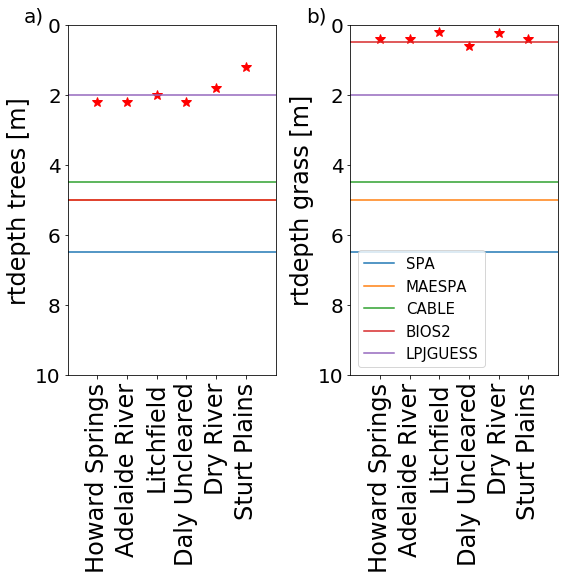

In [29]:
#plot parameters

cpcff_vals = np.arange(0.2,2.8, 0.2)
study_sites = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver", "SturtPlains" ]
site_names = ["Howard Springs", "Adelaide River", "Litchfield", "Daly Uncleared", "Dry River", "Sturt Plains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
fig, (( ax5, ax6) )  = plt.subplots(nrows=1, ncols=2, figsize=(8, 8)) 

icount = 0
for isite in  range(0,6):  
    
    params_tmp = []
    #for icpcff in range(0,len(cpcff_vals)):

        #loop over files and load
    params_tmp = np.loadtxt("../work/" + 
             study_sites[isite] + "/freedrainage_cpcff1.2/best/input/pars.txt") #mm/d
        


    #for irun in range(0,4):
   
    ax5.plot(isite, params_tmp[5], "*r", ms=10)     
    ax6.plot(isite, params_tmp[7], "*r", ms=10) 
    icount = icount + 1 
    
ax5.plot( [-1,6], [6.5,6.5] , label='SPA'  )
ax5.plot( [-1,6], [5, 5] , label='MAESPA'  )
ax5.plot( [-1,6], [4.5,4.5] , label='CABLE'  )
ax5.plot( [-1,6], [5,5] , label='BIOS2'  )
ax5.plot( [-1,6], [2,2] , label='LPJGUESS'  )   
    
    
ax6.plot( [-1,6], [6.5,6.5] , label='SPA'  )
ax6.plot( [-1,6], [5, 5] , label='MAESPA'  )
ax6.plot( [-1,6], [4.5,4.5] , label='CABLE'  )
ax6.plot( [-1,6], [0.5,0.5] , label='BIOS2'  )
ax6.plot( [-1,6], [2,2] , label='LPJGUESS'  )
    
#ax2.set_ylim([0,1]) 
ax5.set_xlim( -1, 6  ) 
ax5.set_ylim( 10, 0  ) 

ax5.set_xticks( [0,1,2,3,4,5] )  
ax5.set_xticklabels( site_names, rotation=90, size=24  )  
ax5.set_ylabel("rtdepth trees [m]", size=24 )  

for tick in ax5.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax6.set_xlim( -1, 6  ) 
ax6.set_ylim( 10, 0  ) 

ax6.set_xticks( [0,1,2,3,4,5] )  
ax6.set_xticklabels( site_names, rotation=90, size=24  )  
ax6.set_ylabel("rtdepth grass [m]", size=24 )  
ax6.legend(prop={'size':15})

for tick in ax6.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)


ax5.text( x=-2.5, y=-0.1, s="a)", fontsize = 20)
ax6.text( x=-2.5, y=-0.1, s="b)",  fontsize = 20)

plt.tight_layout()
    
plt.savefig("../data/img/10_rootdepths.png", bbox_inches = "tight")

plt.show()




**Figure 10.** Modelled rooting depths for a) trees and b) grasses, with the results of the VOM shown in red. The colored lines represent the rooting depths of the other models used in Whitley et al. (2016).